# Monte Carlo Additional Material

##  1. Simulating (Pseudo) Random Numbers

The short answer is to call the "rand" or "random" function the programming language/package you're using. In general, this produces a sequence of numbers that behave "like" independent identically distributed (iid) uniform variables over $[0,1]$. The mention "like" comes from the fact that these sequences are generated from deterministic algorithm and only "look" to behave randomly.

A Pseudo-Random Number Generator (PRNG)

One classical way to generate pseudo-random numbers uniformly distributed is to pick a (large) number $N$ and a (smaller) number $a$ such that $gcd(a,N) = 1$ and then define recursively
$$ x_{n+1} = a x_n + b \mod(N) $$

and then set $u_n = \frac{x_n}{N}$. The choice of the numbers $a,b,N$ is critical in order to produce a long sequence of $x_n$ before it becomes cyclic. Such algorithms are not used in modern standards but gives a flavor of what a PRNG is.

A more sophisticated algorithm is the so-called [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister) algorithm. Although not perfect, it is the most popular all-purpose PRNG used in most practical applications. Interested readers can look at this [link](http://www.math.sci.hiroshima-u.ac.jp/m-mat/MT/emt.html).

You can see that it is used in [python](https://docs.python.org/3/library/random.html), in [numpy](https://numpy.org/doc/stable/reference/random/generator.html) and in [c++](https://en.cppreference.com/w/cpp/numeric/random) although it is possible to choose other algorithms as well.

In order to introduce (elements of ) "true" randomness, the seed is sometimes set depending on the time at which the algorithm is called. In practice, this is usually avoided because one usually prefers having reproducible results. 

With the advent of quantum computers, generating **true** random numbers with computers has become possible. 


### 1.1.True and pseudo random numbers

True random number generators (TRNG) observe random physical processes:
* often involves quantum effects: radioactive decay, electrical/thermal noise etc.
* costly and slow
* mostly used in cryptography that requires a high level of security

Pseudo random number generators (PRNG) are computer software that 
* produce number sequence that only appears to be random
* cheap and fast
* can be initialized (seeded) to different states
* states can be stored and recovered, convenient for MC

### 1.2. Pseudo random number generators

Building good P-RNG requires highly specialized skills:

* must pass rigorous statistical tests 
* numerical scientists have devoted their careers to build good P-RNGs
* always use a good P-RNG library and never write your own
  * Initially, ```random()``` in Excel was implemented [incorrectly](http://www.pages.drexel.edu/~bdm25/excel-rng.pdf). Although, since 2010, [Excel](https://support.microsoft.com/en-us/office/rand-function-4cbfa695-8869-4788-8d90-021ea9f5be73) uses the (now) standard MT-19937 algorithm.

####  Mersenne Twister (MT19937)

The most popular P-RNG:
* often the default P-RNG for MC
  * the default choice of Python's ```numpy.random.uniform```
* very long cycle of $2^{19937} − 1$ and excellent statistical properties
* suitable for MC applications, but **not** good for cryptography
* very fast: ~100M random numbers per second on a modern PC

### 1.3. Simulation of Random Variables

The simulation techniques for a random variable $X$ with known distribution assume that we can simulate outcomes from a random variable $U \sim U([0,1])$. Then, one can transform these outcomes to produce other random variables. For instance $U_{[a,b]} = a + U\times(b-a)$ is a uniform variables over $[a, b]$.

In general, noting $F_X(x) = \mathbb{P}(X\leq x)$ the cumulative distribution function (cdf) of $X$, then the variable $Z = F_X^{-1}(U)$ will have the same distribution of $X$ since
$$ \mathbb{P}(Z \leq x) = \mathbb{P}\left(F_X^{-1}(U) \leq x\right) = \mathbb{P}\left(U \leq F_X(x)\right) = F_X(x) $$

Note that this technique also works with discrete (finite or inifinite) random variables.

If $X$ does not follow a standard distribution and you know the density of the variable $X$, then you can use integration to compute $F_X(x) = \int 1_{t\leq x} p(t) dt$, which is a monotonic function, and therefore you can invert it numerically using a solver. This is a brute force method and if performance becomes an issue (it always does), then finding better approximation of $F_X^{-1}$ would be needed, or different simulation methods.

### 1.4. Simulation of Gaussian Random Numbers

#### Box-muller

Gaussian random number generation is the most important of all:
* most widely used distribution in science (although we could argue about whether that's a good thing)
* most quant Finance models are driven by Brownian motions or white noise
* fast and accurate inversion of normal CDF wasn't known till recently

Box-muller is a classic method to transform independent uniform RNs to independent  normal RNs:
* takes 2 independent uniforms and produce 2 independent normals
* its [polar form](http://en.wikipedia.org/wiki/Marsaglia_polar_method) is faster and more stable, and used to be behind Python's ```numpy.random.normal```.
* the polar form is a rejection algorithm: the number of output normal RNs is less than the input uniforms
  * about 21% of input uniforms are rejected (wasted)

#### Normal inversion

Numerical inversion of normal CDF is an effective alternative to generate normal random numbers:
* fast and accurate numerical inversion of the normal CDF was discovered recently but the [orginal repository seems to be offline](http://home.online.no/~pjacklam/notes/invnorm/) but thanks to some passionate people, you can read about it [here](https://stackedboxes.org/2017/05/01/acklams-normal-quantile-function/). **Actual code is at the end of this document**.
* based on polynomial approximation, accuracy is ~$10^{-9}$
* every uniform RN produce a normal RN output, more convenient than the polar Box-muller
* works well with low discrepancy sequences (see lecture)

Normal inversion is often preferred over the Box-muller.

#### Ziggurat Algorithm
Numpy now uses the [Ziggurat](https://en.wikipedia.org/wiki/Ziggurat_algorithm) as indicated [here](https://numpy.org/doc/stable/reference/random/index.html#random-quick-start)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
import sys

In [2]:
# Some Python code to compute densities for classical discrete distributions
    
sampleSize = 10**4
simulData = pd.DataFrame()
simulData['uniform'] = np.random.rand(sampleSize)

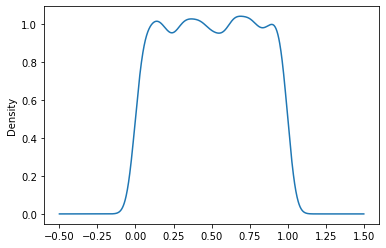

In [3]:
simulData['uniform'].plot.density();

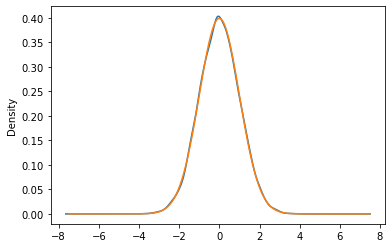

In [4]:
simulData['gaussian'] = np.random.normal(0., 1., sampleSize)
simulData['gaussian'].plot.density()
plt.plot(np.linspace(-7.5, 7.5, sampleSize), norm.pdf(np.linspace(-7.5, 7.5, sampleSize)));

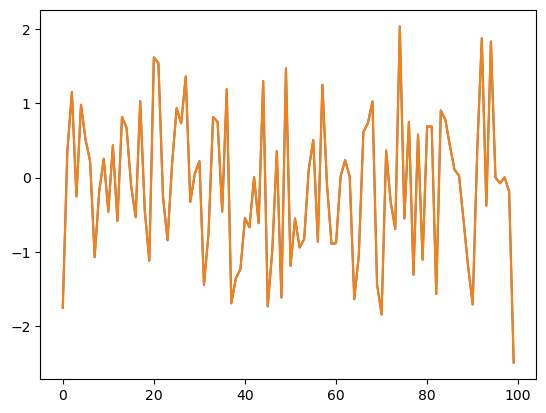

In [2]:
# what happens using the same seed...
sampleSize = 100 # small number so that data are still visually noisy
np.random.seed(100)
X_100_a = np.random.normal(0., 1., sampleSize)
plt.plot(X_100_a)

np.random.seed(100)
X_100_b = np.random.normal(0., 1., sampleSize)
plt.plot(X_100_b);

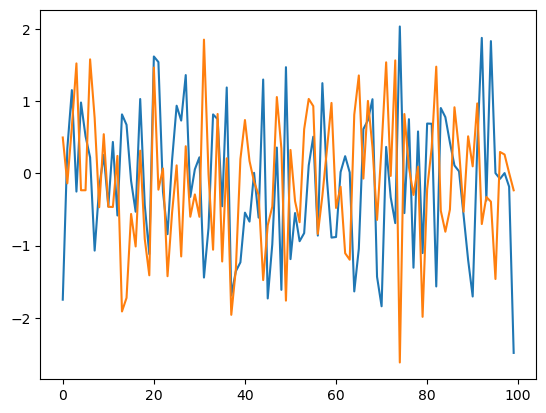

In [3]:
# what happens for different seeds...
sampleSize = 100 # small number so that data are still visually noisy
np.random.seed(100)
X_100 = np.random.normal(0., 1., sampleSize)
plt.plot(X_100)

np.random.seed(42)
X_42 = np.random.normal(0., 1., sampleSize)
plt.plot(X_42);

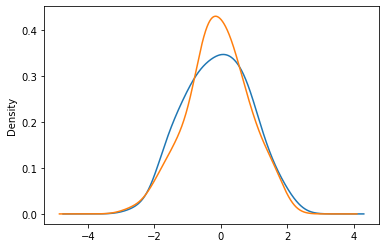

In [6]:
simulData = pd.DataFrame()
simulData['gaussian_100'] = X_100
simulData['gaussian_42'] = X_42
simulData['gaussian_100'].plot.density()
simulData['gaussian_42'].plot.density();

#### Exercise
* Re-run the above 2 cells with sampleSize = $10^5$
* Produce more examples on classic distributions

## 2. A Classic Example

Computing the value of $\pi$ using Monte Carlo:

* randomly throw dots to a 1x1 square, and count the percentage of dots falling into the quarter circle
* the percentage of dots within the unit circle in the first quadrant should be $\frac{\pi}{4}$ in the limit
* with a large number of dots, $4 \times$ the percentage $\rightarrow \pi$. 

In [7]:
def sim_pi(ns) :
    es = np.random.uniform(size=[ns[-1], 2])
    d = np.array([x*x + y*y < 1. for x, y in es])
    
    return np.array([4.*np.sum(d[:n])/n for n in ns])

ns = 4**(np.arange(8))*100
ps = sim_pi(ns)

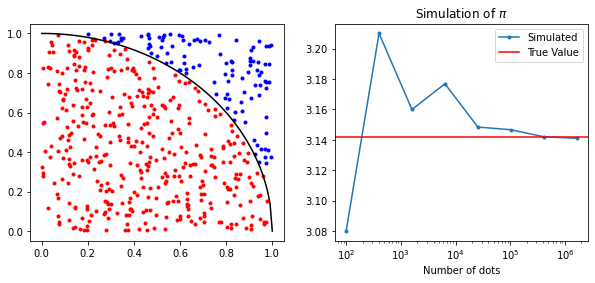

In [8]:
plt.figure(figsize=[10, 4])
plt.subplot(1, 2, 1)


es = np.random.uniform(size=[500, 2])
d = np.array([x*x + y*y < 1. for x, y in es])
dn = np.logical_not(d)
plt.plot(es[d,0], es[d,1], 'r.');
plt.plot(es[dn,0], es[dn,1], 'b.');
x = np.arange(0, 1.01, .01)
plt.plot(x, np.sqrt(1-x*x), 'k');

plt.subplot(1, 2, 2)

plt.semilogx(ns, ps, '.-');
plt.axhline(np.pi, color='r')
plt.legend(['Simulated', 'True Value'], loc='best')

plt.xlabel('Number of dots')
plt.title('Simulation of $\pi$');

## 3. Population, Samples and Error Control

### 3.1. Population
Given a random variable $Y$, its true statistics are referred as the population statistics:

* population mean:  $\mu_Y = \mu = \mathbb{E}[Y]$
* population variance: $\sigma_Y^2 = \sigma^2 = \mathbb{E}[\tilde Y^2] - \mu^2$

We use $ \boldsymbol y = [y_1, y_2, ..., y_n]^T$ to represent samples of $Y$:
* samples can be multiple observations of the random variable.
* or multiple draws from the population distribution.

### 3.2. Sample Mean and Variance
The sample mean is the arithmetic average of the sample
$$\hat{\mu} = \frac{1}{n}\sum_{i=1}^n y_i $$

Note that $\hat \mu$ is an unbiased estimator of the population mean $\mu$: 
$$\mathbb{E}[\hat{\mu}] = \frac{1}{n} \sum_{i=1}^n E(y_i) = \frac{1}{n} n \mu = \mu $$

The variance of the sample mean is given by:
$$\text{var}[\hat{\mu}] = \text{cov}\left(\frac{1}{n}\sum_{i=1}^n y_i, \frac{1}{n}\sum_{j=1}^n y_j \right) = \frac{1}{n^2} \sum_i \sum_j cov(y_i, y_j) = \frac{1}{n^2} \sum_{i=1}^n \text{var}(y_i) = \frac{\sigma^2}{n}$$

and one can see that the std dev of $\hat{\mu}$ decreases at a rate of $\frac{1}{\sqrt{n}}$. This also gives that $E(\hat{\mu}^2) = \text{var}(\hat{\mu}) + \mu^2 = \frac{\sigma^2}{n} + \mu^2$.

The sample mean of the centered squared error, noted $\hat \sigma^2$, is often used to estimate the variance of the sample:
$$\hat{s}^2 = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{\mu})^2 $$

$\hat{s}^2$ is a **biased** estimator of the population variance $\sigma^2$ as:
\begin{split}
\mathbb{E}(\hat{s}^2) &= \mathbb{E}\left[\frac{1}{n}\left( \sum_{i=1}^n y_i^2 - 2 y_i \hat{\mu} + \hat{\mu}^2 \right)\right] = \mathbb{E}\left(\frac{1}{n} \sum_{i=1}^n y_i^2 \right)  - \mathbb{E}(\hat \mu^2) \\
&= \sigma^2 + \mu^2 - \left(\frac{\sigma^2}{n} + \mu^2\right) = \frac{n-1}{n} \sigma^2
\end{split}


This shows that $\hat{\sigma}^2 = \frac{n}{n-1}\hat{s}^2 = \frac{1}{n-1} \sum_{i=1}^n (y_i - \hat{\mu})^2$ is therefore an **unbiased** estimator of $\sigma^2$.

### 3.3. Central Limit Theorem
If $(Y_i)_{i \geq 1}$ is an iid sequence of **squared integrable** random variable (i.e. $E(Y^2) < +\infty$), then noting $\hat{\mu}_N = \frac{1}{N} \sum_{i=1}^N Y_i$ and $\hat{\sigma_N} = \sqrt{\frac{1}{N-1} \sum_{i=1}^N(Y_i - \hat{\mu}_i)^2}$ then
$$ \sqrt{N} \frac{\hat{\mu}_N - E(Y)}{\hat{\sigma}_N} \to \mathcal{N}(0,1) $$
where the convergence is in distribution.

This provides a useful way to control the MC error (also called statistical error) when using MC simulation, as if $N$ is large enough, then
$$ \mathbb{P}\left( \left| \sqrt{N} \frac{\hat{\mu}_N - E(Y)}{\hat{\sigma}_N} \right| \leq \epsilon \right) \approx \mathbb{P}( |N| \leq \epsilon) = 2\Phi(\epsilon)-1 $$

but since 
$$ \mathbb{P}\left( \left| \sqrt{N} \frac{\hat{\mu}_N - E(Y)}{\hat{\sigma}_N} \right| \leq \epsilon \right)
= \mathbb{P}\left(| \hat{\mu}_N - E(Y)| \leq \epsilon \frac{\hat{\sigma}_N}{\sqrt{N}} \right)
= \mathbb{P}\left(  \hat{\mu}_N - \epsilon\frac{\hat{\sigma}_N}{\sqrt{N}} \leq E(Y) \leq \hat{\mu}_N + \epsilon\frac{\hat{\sigma}_N}{\sqrt{N}}  \right)$$

Then for $N$ large enough, choosing $\epsilon = 1.96$ gives a 95\% confidence interval, $\epsilon = 2.58$ a 99\% confidence interval...

The above results should give you a feel as to why most MC methods have a $O\left(N^{-\frac{1}{2}}\right)$ convergence rate.

<div class="alert alert-block alert-danger">
Note that the distributions below may not work well when trying to use MC simulation:
</div>

- [Student's](https://en.wikipedia.org/wiki/Student%27s_t-distribution) distribution with a number of freedom $1<\nu \leq 2$.
- [Pareto](https://en.wikipedia.org/wiki/Pareto_distribution) distribution with $\alpha < 1$.
- The [Frechet](https://en.wikipedia.org/wiki/Fr%C3%A9chet_distribution) distribution for some specification of parameters.
- Linked to the Frechet distribution, the [Generalized Extreme Value](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution) distribution arising in Extreme Value Theory.

### 3.4. Remark on the Sample Standard Deviation

Let's consider the quantity:
 $$\hat \sigma_n = \sqrt{\hat \sigma_n^2} = \sqrt {\frac{1}{n-1}\sum_{i=1}^n (y_i - \hat{\mu})^2} $$
 
* $\sigma_n $ is routinely used as an estimator for $\sigma$ a suggested by the Central Limit theorem
* under the assumption that $y_i$ is Gaussian, $\hat s$ follows Chi distribution (with (n-1) degrees of freedom), which converges to normal for large $n$
* error and standard deviation $\hat \sigma_n$ are often used interchangeably

Is standard deviation is an unbiased estimator of $\sigma$?
* **No**, because of Jensen's inequality:

$$ \mathbb{E}[\hat \sigma_n] = \mathbb{E}\left[\sqrt{\hat \sigma_n^2} \right] \le \sqrt{\mathbb{E}[\hat \sigma_n^2]} = \sqrt{\sigma^2} = \sigma$$

A second order correction yields:
$$ \mathbb{E}[\sqrt{\hat \sigma_n^2}] \approx \sqrt{\mathbb{E}[\hat \sigma_n^2]} - \frac{1}{8} \frac{\text{var}(\hat \sigma_n^2)}{ \mathbb{E}(\hat \sigma_n^2)^{3/2}} $$


### 3.5. Variance of sample variance

$$\text{var}[\hat \sigma_n^2] = \frac{1}{n}\left(\mu_4 - \sigma^4 \frac{n-3}{n-1}\right) \approx \frac{\kappa - 1}{n} \sigma^4$$

  * $\mu_4 = \mathbb{E}[(Y - \mu)^4]$, population's 4th central moment
  * $\kappa = \frac{\mu_4}{\sigma^4}$ is the population's kurtosis
  * Check [here](http://math.stackexchange.com/questions/72975/variance-of-sample-variance) for the derivation

### 3.6. Numerical examples

Consider the example of computing $\pi$ using MC:


$$\frac{\pi}{4} = \mathbb{E}\left[1{\hskip -2.5 pt}\hbox{l}\left(\sqrt{X^2 + Y^2} < 1\right)\right]$$

where $1{\hskip -2.5 pt}\hbox{l} (\cdot)$ is an indicator function. We further note $\tilde 1{\hskip -2.5 pt}\hbox{l} = 1{\hskip -2.5 pt}\hbox{l}\left(\sqrt{X^2 + Y^2} < 1\right)$ so that the population mean, variance and 4th moment are:

$$\begin{array}{l}
\mu = \mathbb{E}[\tilde 1{\hskip -2.5 pt}\hbox{l}] = \frac{\pi}{4} \\
\sigma^2 = \text{var}[\tilde 1{\hskip -2.5 pt}\hbox{l}] = \mathbb{E}[\tilde 1{\hskip -2.5 pt}\hbox{l}^2] - \mu^2 = \frac{4\pi - \pi^2}{16} \\
\mu_4 = \mathbb{E}\left[\left(\tilde 1{\hskip -2.5 pt}\hbox{l} - \mu\right)^4\right] = \frac{\pi}{4}(1-\frac{\pi}{4})^4 + (1-\frac{\pi}{4})(\frac{\pi}{4})^4 \\
\kappa = \frac{\mu_4}{\sigma^4} = 2.933
\end{array}
$$

The variance and error of sample statistics:

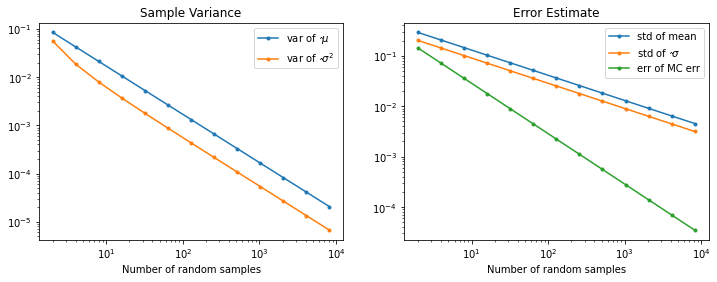

In [9]:
u = np.pi/4
v = u*(1-u)
u4 = np.pi/4*(1-np.pi/4)**4 + (1.-np.pi/4)*(np.pi/4)**4

ns = 2**(np.arange(1, 14))
var_u = v/ns
var_var = (u4 - v*v*(ns-3)/(ns-1))/ns

kappa = u4/v**2

fig = plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.loglog(ns, np.transpose([var_u, var_var]), '.-')
plt.legend(['var of $\hat \mu$', 'var of $\hat \sigma^2$']);
plt.xlabel('Number of random samples')
plt.title('Sample Variance');

ax = fig.add_subplot(122)
plt.loglog(ns, np.transpose([np.sqrt(var_u), np.sqrt((kappa-1.)/4./ns)*np.sqrt(v), np.sqrt((kappa-1.))/2./ns*np.sqrt(v)]), '.-');
plt.title('Error Estimate')
plt.legend(['std of mean', 'std of $\hat \sigma$', 'err of MC err'], loc='best');
plt.xlabel('Number of random samples');

* it is prudent to monitor the error of MC error
* the esimation error of the MC error itself is more pronounced for fat tailed distributions, with large $\kappa$

### 3.7. Batching

Advanced MC techniques often involves dependent samples 
* the MC error estimate of $\frac{\hat \sigma}{\sqrt{n}}$ is no longer valid

Batching is a generic method to estimate MC errors with dependent samples
* Repeat the MC simulation $b$ times, and obtain $\hat{\mu}_i$ for $i = 1 ... b$ 
  * each batch needs to have **different** random seeds
* Therefore the $\hat{\mu}_i$ are independent between batches, 
  * the variance of $\hat \mu$ can be estimated directly  $\hat \sigma_b^2 = \frac{1}{b-1} \sum_i (\mu_i^2 - \bar{\mu})^2$ 
  * $\bar{\mu} = \frac{1}{b} \sum_i\hat{\mu}_i$ is the batch mean estimator, its error is $\frac{\hat \sigma_b}{\sqrt{b}}$

## 4. Brownian Motion Interpolation with a Brownian Bridge

Sometimes, we want to interpolate stochastically using Brownian motion:

* Fill in missing historical data
* Pricing model needs finer steps than what the simulation model produces (e.g. continuously monitored barrier options, american options, etc.)
* The exact stochastic path is costly to compute, we want to approximate the true path using larger sampling steps

Suppose $\boldsymbol W_t$ is a n-dimensional brownian motion, and we want to force that Brownian motions to be reach a.s. a **known** terminal $\boldsymbol w_T$. This can be done by considering the Gaussian process defined by:
$$ \boldsymbol W_b(t) = \boldsymbol W_t - \frac{t}{T} (\boldsymbol W_T - \boldsymbol w_T)$$ 

which is a Brownian Bridge from $W_0 = 0$ to $w_T$. Note that $\boldsymbol W_t$ can be correlated.

This results is a simple artifact of $E(W_t | W_T) = \frac{t}{T}W_T$ for $t\leq T$ (note that the martingale property of BM is the other way around!).


**Exercise 1:** calculate the covariance function of $W_b(t)$.

**Exercise 2:** how do you build a Brownian bridge which starts at some known value $w_{start}$?


### 4.1. Examples of Brownian Bridge

A one dimensional Brownian Bridge with $w_1 = 10$:

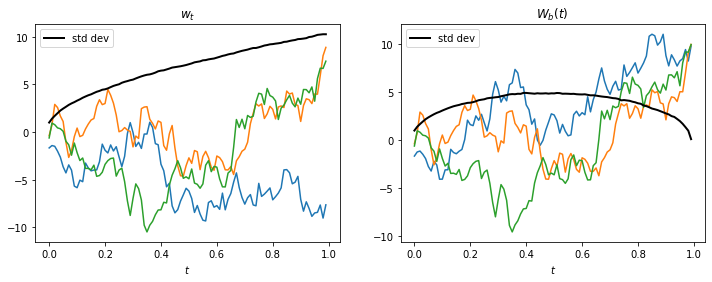

In [10]:
nt = 100
w = np.cumsum(np.random.normal(size=[1000, nt]), 1)
dt = np.arange(nt)/nt

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.plot(dt, w[:3, :].T, label="_nolegend_")
plt.plot(dt, np.std(w, 0), 'k', linewidth=2)
plt.legend(["std dev"])
plt.title("$w_t$")
plt.xlabel("$t$")

ve = 10
plt.subplot(1, 2, 2)
b = np.array([p - (p[-1] - ve)*dt for p in w])
plt.plot(dt, b[:3, :].T, label="_nolegend_")
plt.plot(dt, np.std(b, 0), 'k', linewidth=2)
plt.legend(["std dev"])
plt.title("$W_b(t)$")
plt.xlabel("$t$");

## 5. Discretization of Stochastic Processes

Let's consider the general SDE of the form:
$$ dX_t = \mu(t,X_t) dt + \sigma(t,X_t) dW_t $$

In general, it is not possible (or difficult) to have an exact scheme and one would resort to numerical approximations.

### 5.1. The Euler Scheme

The Euler scheme is the simplest and most widely used approximation scheme. It relies on the following approximation
\begin{split}
X_{t+h} &= X_t + \int_t^{t+h} \mu(u,X_u)du + \int_t^{t+h} \sigma(u,X_u)dW_u \\
& \approx X_t + \mu(t,X_t) h +\sigma(t,X_t)(W_{t+h} - W_t)
\end{split}

It is therefore natural to define the following approximation of $X_t$ for $0=t_0 < t_1 < ... < t_N = T$ as:
\begin{split}
\tilde X_0^N &= X_0 \\
\tilde X_{t_{i+1}}^N & = \tilde X_{t_i}^N + \mu(t_i,\tilde X_{t_i}^N) \Delta t_i + \sigma(t_i,\tilde X_{t_i}^N)\Delta W_{t_i} 
\end{split}

Then the processes can be linearly interpolated so as to be continuous and will therefore satisfy the same SDE as $X_t$ but at discrete time steps.

#### Strong Convergence
Under Lipschitz assumption on the SDE coefficients, we have
$$ \mathbb{E} \left( \sup_{t \in [0,T} |X_t - \tilde X_t^N |^p \right)^{\frac{1}{p}} \leq \frac{C}{\sqrt{N}} $$

#### Weak Convergence

The above result is useful for path dependence as it depends on the whole trajectory of the process, but when only considering the distribution of $X_T$ compared to $\tilde X_T^N$. If $\mu$ and $\sigma$ are $\mathcal{C}^4$ and bounded while $g$ is also $\mathcal{C}^4$ with polynomial growth, then 
$$ E\left( |g(X_T) - g(X_T^N)| \right) \leq \frac{C}{N} $$

Reference: Talay D., "Discrétisation d'une équation différentielle stochastique et calcul approché d'espérances de fonctionnelles de la solution", Mathematical Modelling and Numerical Analysis, 20, 141-179, 1986.

### 5.2. The Milshtein Scheme

For the Euler scheme, a left-Riemann approximation was used for $\int_t^{t+h} \sigma(u,X_u)dW_u$. If the function $\sigma$ is smooth, we can apply a first order expansion in the second variable. Ignoring the drift (and the time dimension), one writes:
$$ \sigma(u,X_u) \approx \sigma\left(u,X_t + \int_t^u \sigma(s,X_s) dW_s\right) \approx \sigma(t, X_t) + \partial_x \sigma(t,X_t) \sigma(t,X_t)(W_u-W_t)$$

one easily gets:
$$ \int_t^{t+h}(W_u-W_t)dW_u = \frac{1}{2} \left( (W_{t+h}-W_t)^2 - h\right) $$

so that
$$ \int_t^{t+h} \sigma(u,X_u)dW_u \approx \sigma(t, X_t)(W_{t+h} - W_t) + \frac{1}{2} \partial_x \sigma(t,X_t) \sigma(t,X_t)\left( (W_{t+h}-W_t)^2 - h\right) $$

which appears to be the Euler scheme with a second order (martingale) correction .


The regularity of the function $\sigma$ is **crucial** and this scheme can perform **poorly** for **non-parametric volatility models**.

The Milshtein scheme is still interesting for its convergence property, which states that for bounded $\mathcal{C}^2$ coefficients $\mu$ and $\sigma$, then 
$$ \max_{0 \leq i \leq N} E\left( |X_{t_i} - \tilde{X}_{t_i}|^p\right)^{\frac{1}{p}} \leq \frac{C}{N} $$


**NB:** The Milshtein scheme is difficult to implement in dimensions higher than 2. 


### 5.3. CIR process

The Cox-Ingersoll-Ross (CIR) process is defined as the solution to:
$$dX_t = \kappa(\theta - X_t) dt + \sigma \sqrt{X_t} dW_t$$

* We have $X_t > 0$, if $\sigma^2 < 2\kappa \theta$ (the so-called Feller condition) . 
* No known analytical solution for $x(t)$
* Often used to model [interest rates](https://www.jstor.org/stable/1911242?origin=crossref&seq=1) and volatility, e.g. [Heston model](https://academic.oup.com/rfs/article-abstract/6/2/327/1574747?redirectedFrom=fulltext)


The Feller condition often fails in practice, which means that $\mathbb{P}(\exists t\in[0,T] s.t. X_t = 0) > 0$ could be non-negligible.


Remarks:
* Euler discretization could lead to negative values for $\tilde X_t$ even if the Feller condition is satisfied. As such, in practice, ad-hoc floors or reflections are often used to avoid negative values, at the cost of (potentially significant) bias in $\tilde X_t$. The simplest trick is to use $(\tilde X_{t_{i+1}})^+$ and $(\tilde X_{t_i})^+$
* There exists an [exact simulation scheme](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1153950), but is very computational expensive and therefore is used only for benchmarking purposes.
* The Milstein scheme can lead to numerical instability because $(\sqrt{x})' = \frac{1}{2\sqrt{x}}$ could lead to an overflow error.
* Simple effective schemes often used in performance benchmarks are probably those from [Lief Andersen](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=946405).
* Higher order schemes also exist (see [Alfonsi1](https://hal.archives-ouvertes.fr/hal-00143723v5/document) and [Alfonsi2](https://cermics.enpc.fr/~alfonsi/SC_preprint.pdf))

### 5.4. Remark on the Stability of Euler Scheme with (too) large time step

Consider a one-dimensional OU process, and its Euler discretization:

$$\small 
\begin{array}{l}
dx(t) = \kappa(\bar x - x(t)) dt + \sigma dW_t \\
x(t_{i+1}) = x(t_i) + \kappa(\bar x - x(t_i)) \delta + \sqrt{\delta} \sigma \epsilon_i \\
x(t_{i+1}) = (1 - \kappa \delta) x(t_i) + \kappa \bar x \delta + \sqrt{\delta} \sigma \epsilon_i \\
\mathbb{E}[x(t_{i+1})] = (1 - \kappa \delta) \mathbb{E}[x(t_i)] + \kappa \bar x \delta
\end{array}$$

the expectation explodes if the $| 1 - \kappa \delta | > 1$, i.e., $\delta > \frac{2}{\kappa}$

In [11]:
# A couple of "helper" functions

def generate_z1(n_paths, dt, t_maturity):
    '''
    Function for generating a matrix of normal random variables
    
    Inputs:
        n_paths: number of paths
        dt: the size of the time steps
        t_maturity: time to maturity
                
    Output: returns a normalized matrix of normal random variables
        matrix is (M X N), where M = number of paths and
        N = number of time steps
    
    RRL February 22, 2022
    
    '''

    import numpy as np
    np.random.seed(42)
    n_time_steps = int(t_maturity/dt + 1e-6)
    z1 = np.random.normal(size=n_paths*n_time_steps) # get the right number of rv's
    z1 = (z1 - z1.mean())/z1.std() # normalize so they are N(0,1)
    z_matrix = z1.reshape(n_paths,n_time_steps) # reshape to proper dimension
    
    return z_matrix, n_time_steps

###########################################################################################

def OU_process(z, x0, k, theta, sigma, dt):
    '''
    Function for generating an array of stock prices from 
    Geometric Brownian Motion under a Q-measure
    
    Inputs:
        z: a matrix of normal rv's [number of paths, number of time steps]
        x0: Stock price at time 0
        r: the risk-free rate
        sigma: the volatility
        dt: the size of the time-steps
        
    Output: returns an array of prices with size = [number of paths, number of time steps]
    
    RRL February 22, 2022
    
    '''
    
    import numpy as np
    x_s = []
    x = np.ones(len(z)) * x0
    for e in z.T:
        x = x + k * (theta - x) * dt + sigma * e * np.sqrt(dt)
        x_s.append(x)

    return np.array(x_s).T

###########################################################################################

In [12]:
x0 = 0
k= 10
theta = 0.05
sigma = 0.02
n_paths = 1
dt = 2/k # critical value for stability of simulation
t_maturity = 20

z, n_time_steps = generate_z1(n_paths, dt, t_maturity)

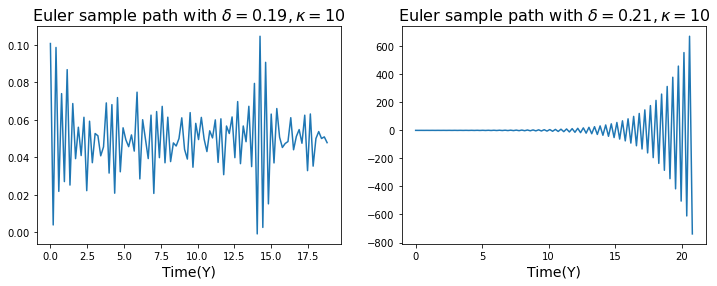

In [13]:
et = .01 # adjustment to dt

# plot where expectation does not explode
plt.figure(figsize=[12, 4]);
plt.subplot(1, 2, 1)
dt = 2/k - et
paths = OU_process(z, x0, k, theta, sigma, dt)
plt.plot(np.arange(n_time_steps)*dt, paths.T)
plt.xlabel('Time(Y)', fontsize=14);
plt.title('Euler sample path with $\delta = %g, \kappa=%g$' % (dt, k), fontsize=16);

# plot where expectation does explode
plt.subplot(1, 2, 2)
dt = 2/k + et
paths = OU_process(z, x0, k, theta, sigma, dt)
plt.plot(np.arange(n_time_steps)*dt, paths.T)
plt.xlabel('Time(Y)', fontsize=14);
plt.title('Euler sample path with $\delta = %g, \kappa=%g$' % (dt, k), fontsize=16);

### 5.5. More Examples of Simulation Schemes

The log-Euler scheme yields an exact simulation for lognormal processes with constant parameters. For general strictly positive processes, Ito's formula yields
$$ d\log(X_t) = \frac{dX_t}{X_t} - \frac{1}{2} \frac{\sigma^2(t,X_t)}{X_t^2} dt = \left( \frac{\mu(t,X_t)}{X_t}  - \frac{1}{2} \frac{\sigma^2(t,X_t)}{X_t^2} \right) dt + \frac{\sigma(t,X_t)}{X_t} dW_t $$

The Euler scheme is then applied, leading to
$$  \log \left( \frac{ X_{t_{n+1}} }{ X_{t_n} } \right) = \left( \frac{ \mu(t_n, X_{t_n})}{X_{t_n}}  - \frac{1}{2} \frac{\sigma^2(t_n,X_{t_n})}{X_{t_n}^2} \right) \Delta t_n + \frac{\sigma(t_n,X_{t_n})}{X_{t_n}} \Delta W_{t_n} $$
$$ X_{t_{n+1}}  = X_{t_n} e^{\left( \frac{ \mu(t_n, X_{t_n})}{X_{t_n}}  - \frac{1}{2} \frac{\sigma^2(t_n,X_{t_n})}{X_{t_n}^2} \right) \Delta t_n + \frac{\sigma(t_n,X_{t_n})}{X_{t_n}} \Delta W_{t_n}}$$


## 6. Discretization vs Monte Carlo error

Suppose we have a fixed size time step $\delta = t_{i+1} - t_i = \frac{T}{N}$, and we draw $n$ independent paths of $\hat X(\boldsymbol \tau; \delta)$, where $\boldsymbol \tau$ consists of $m$ discrete time samples.
* the total computation cost is $\propto mn$

There are two types of errors in Monte Carlo simulation of SDEs:

* Discretization error:  $\epsilon_d \propto (\frac{1}{m})^\gamma$
* Monte Carlo (i.e. statistical) error: $\epsilon_{s} \propto \frac{1}{\sqrt{n}}$

The two types of errors are independent, thus the total variance is:

$$ \epsilon^2 = c_1 \epsilon_d^2 + c_2\epsilon_{s}^2 = \frac{c_1}{m^{2\gamma}} + \frac{c_2}{n}$$

* where $c_1, c_2$ are constant (likely unknown) 

### 6.1. Optimal choice of $\delta$

Given a fixed computation budget of $mn = c$, the best allocation between $m$ and $n$ can be found by solving:

$$\begin{array}{c} \min_{m, n} \left(\frac{c_1}{m^{2\gamma}} + \frac{c_2}{n}\right) \\
\text{subject to: } mn = c
\end{array}$$

apply the Lagrange multiplier:

$$\small \begin{array}{l} 
l &= \left(\frac{c_1}{m^{2\gamma}} + \frac{c_2}{n}\right) + \lambda(mn - c) \\
\frac{\partial l}{\partial m} &= -c_1\frac{2\gamma}{m^{2\gamma+1}} + \lambda n = 0 \\
\frac{\partial l}{\partial n} &= -c_2\frac{1}{n^2} + \lambda m = 0 \\
\lambda mn &= \frac{2c_1\gamma}{m^{2\gamma}} = \frac{c_2}{n}
\end{array}$$

therefore the optimal strategy is to maintain $\frac{m^{2\gamma}}{n} = \frac{2c_1\gamma}{c_2}$

### 6.2. Richardson extrapolation

Recall Euler discretization is of 1st order weak convergence:

$$\mathbb{E}[f(\hat X(t; \delta))] = \mathbb{E}[f(\boldsymbol X_t)] + c \delta + O(\delta^2)$$

Richardson extrapolation can be applied to get 2nd order weak convergence: 

$$\begin{array}{l} 
\mathbb{E}[f(\hat X(t; 2\delta))] = \mathbb{E}[f(\boldsymbol X_t)] + 2c \delta + O(\delta^2) \\
2\mathbb{E}[f(\hat X(t; \delta))] - \mathbb{E}[f(\hat X(t; 2\delta))] = \mathbb{E}[f(\boldsymbol X_t)] + O(\delta^2) \\
\mathbb{E}[2f(\hat X(t; \delta)) - f(\hat X(t; 2\delta))] = \mathbb{E}[f(\boldsymbol X_t)] + O(\delta^2)
\end{array}$$

Therefore the estimator $2f(\hat X(t; \delta)) - f(\hat X(t; 2\delta))$ is 2nd order weak convergence.

### 6.3. Cost of Richardson extrapolation

The variance of the estimator with Richardson extrapolation is:

$$\small \begin{array}{l}
\text{var}[2f(\hat X(t; \delta)) - f(\hat X(t; 2\delta))] \\
= \text{var}\left[2f(\hat X(t; \delta))\right] + \text{var}\left[f(\hat X(t; 2\delta))\right] - 2 \\text{cov}\left[2f(\hat X(t; \delta)), f(\hat X(t; 2\delta))\right]  \\
= 4\sigma_\delta^2 + \sigma_{2\delta}^2 - 2\rho\sigma_\delta\sigma_{2\delta} \gtrsim 3\sigma^2
\end{array}$$

* Given $\sigma_{2\delta} \approx \sigma_\delta \approx \sigma$, the minimal variance is ~$3\sigma$ when $\rho = 1$
* Richardson extrapolation increases the MC cost by a factor of 3 at least.

### 6.4. Richardson extrapolation implementation

The following implementation maximizes the correlation between $f(\hat X(t; \delta))$ and $f(\hat X(t; 2\delta))$:  

1. draw $m$ independent standard normal random vectors: $\boldsymbol z_1,  \boldsymbol z_2, 
\boldsymbol z_3, ..., \boldsymbol z_m$,  
2. use $\boldsymbol z_1\sqrt{\delta}, \boldsymbol z_2\sqrt{\delta}, \cdots , \boldsymbol z_m\sqrt{\delta}$ as the Brownian motion increments to simulate $\hat X(t; \delta)$
3. use  $(\boldsymbol z_1 + \boldsymbol z_2)\sqrt{\delta}, (\boldsymbol z_3+\boldsymbol z_4)\sqrt{\delta}, \cdots $ as the Brownian motion increments to simulate $\hat X(t; 2\delta)$

# Extra
This is the `python` code for computing the inverse normal:

In [ ]:
def ltqnorm( p ):
    """
    Modified from the author's original perl code (original comments follow below)
    by dfield@yahoo-inc.com.  May 3, 2004.

    Lower tail quantile for standard normal distribution function.

    This function returns an approximation of the inverse cumulative
    standard normal distribution function.  I.e., given P, it returns
    an approximation to the X satisfying P = Pr{Z <= X} where Z is a
    random variable from the standard normal distribution.

    The algorithm uses a minimax approximation by rational functions
    and the result has a relative error whose absolute value is less
    than 1.15e-9.

    Author:      Peter John Acklam
    Time-stamp:  2000-07-19 18:26:14
    E-mail:      pjacklam@online.no
    WWW URL:     http://home.online.no/~pjacklam
    """

    if p <= 0 or p >= 1:
        # The original perl code exits here, we'll throw an exception instead
        raise ValueError( "Argument to ltqnorm %f must be in open interval (0,1)" % p )

    # Coefficients in rational approximations.
    a = (-3.969683028665376e+01,  2.209460984245205e+02, \
         -2.759285104469687e+02,  1.383577518672690e+02, \
         -3.066479806614716e+01,  2.506628277459239e+00)
    b = (-5.447609879822406e+01,  1.615858368580409e+02, \
         -1.556989798598866e+02,  6.680131188771972e+01, \
         -1.328068155288572e+01 )
    c = (-7.784894002430293e-03, -3.223964580411365e-01, \
         -2.400758277161838e+00, -2.549732539343734e+00, \
          4.374664141464968e+00,  2.938163982698783e+00)
    d = ( 7.784695709041462e-03,  3.224671290700398e-01, \
          2.445134137142996e+00,  3.754408661907416e+00)

    # Define break-points.
    plow  = 0.02425
    phigh = 1 - plow

    # Rational approximation for lower region:
    if p < plow:
       q  = np.sqrt(-2*np.log(p))
       return (((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) / \
               ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)

    # Rational approximation for upper region:
    if phigh < p:
       q  = np.sqrt(-2*np.log(1-p))
       return -(((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) / \
                ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)

    # Rational approximation for central region:
    q = p - 0.5
    r = q*q
    return (((((a[0]*r+a[1])*r+a[2])*r+a[3])*r+a[4])*r+a[5])*q / \
           (((((b[0]*r+b[1])*r+b[2])*r+b[3])*r+b[4])*r+1)